In [1]:
from chessnet.notebook_config import *

In [2]:
graphs = {"OTB": read_pickle(Database.OTB), "Portal": read_pickle(Database.Portal)}

In [3]:
ran_graphs = {
    "OTB": read_rewired_graph(Database.OTB, nswap_ecount_times=10.0),
    "Portal": read_rewired_graph(Database.Portal, nswap_ecount_times=10.0)
}

In [4]:
comm_data = {
    "OTB": pickle.load(open(ARTIFACTS_DIR / f"{Database.OTB}_leiden.pickle", "rb")),
    "Portal": pickle.load(open(ARTIFACTS_DIR / f"{Database.Portal}_leiden.pickle", "rb"))
}

In [5]:
ran_comm_data = {
    "OTB": pickle.load(open(ARTIFACTS_DIR / f"{Database.OTB}_rewired_f10.0_leiden.pickle", "rb")),
    "Portal": pickle.load(open(ARTIFACTS_DIR / f"{Database.Portal}_rewired_f10.0_leiden.pickle", "rb"))
}

In [6]:
for database in ["OTB", "Portal"]:
    print(
        database,
        comm_data[database].newman_girvan_modularity().score,
        ran_comm_data[database].newman_girvan_modularity().score
    )

OTB 0.6473247385781495 0.11527016351414966
Portal 0.3987726422054368 0.06641840421449105


In [8]:
def comms_to_comms_by_id(g, comms):
    name_dict = {name: i for i, name in enumerate(g.vs["name"])}
    comms_by_id = []
    for comm in comms.communities:
        comms_by_id.append([name_dict[name] for name in comm])
    return comms_by_id

In [9]:
def get_community_data(g, communities, min_size: int = 1):
    data = []
    for comm in communities:
        Nc = len(comm)
        if Nc < min_size:
            continue
        comm_elos = [g.vs[index]["MeanElo"] for index in comm]
        row = [Nc, np.mean(comm_elos), np.std(comm_elos)]
        data.append(row)

    df = pd.DataFrame(
        data,
        columns=["Nc", "MeanElo", "StdElo"]
    ).sort_values(by="MeanElo", ascending=False).reset_index(drop=True)
    df["CV"] = df.StdElo / df.MeanElo
    return df

In [10]:
def plot_elo_per_community(df, ax = None):
    if ax is None:
        _, ax = plt.subplots()
    X = df.index+1
    Y = df.MeanElo
    Yerr = df.StdElo
    Yfill_min = Y - Yerr
    Yfill_max = Y + Yerr
    ax.scatter(X, Y, s=10*np.log(df.Nc), color=f"C{i}")
    ax.fill_between(X, Yfill_min, Yfill_max, alpha=0.5, color=f"C{i}")
    return ax

/tmp/ipykernel_398275/1163558759.py:55: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


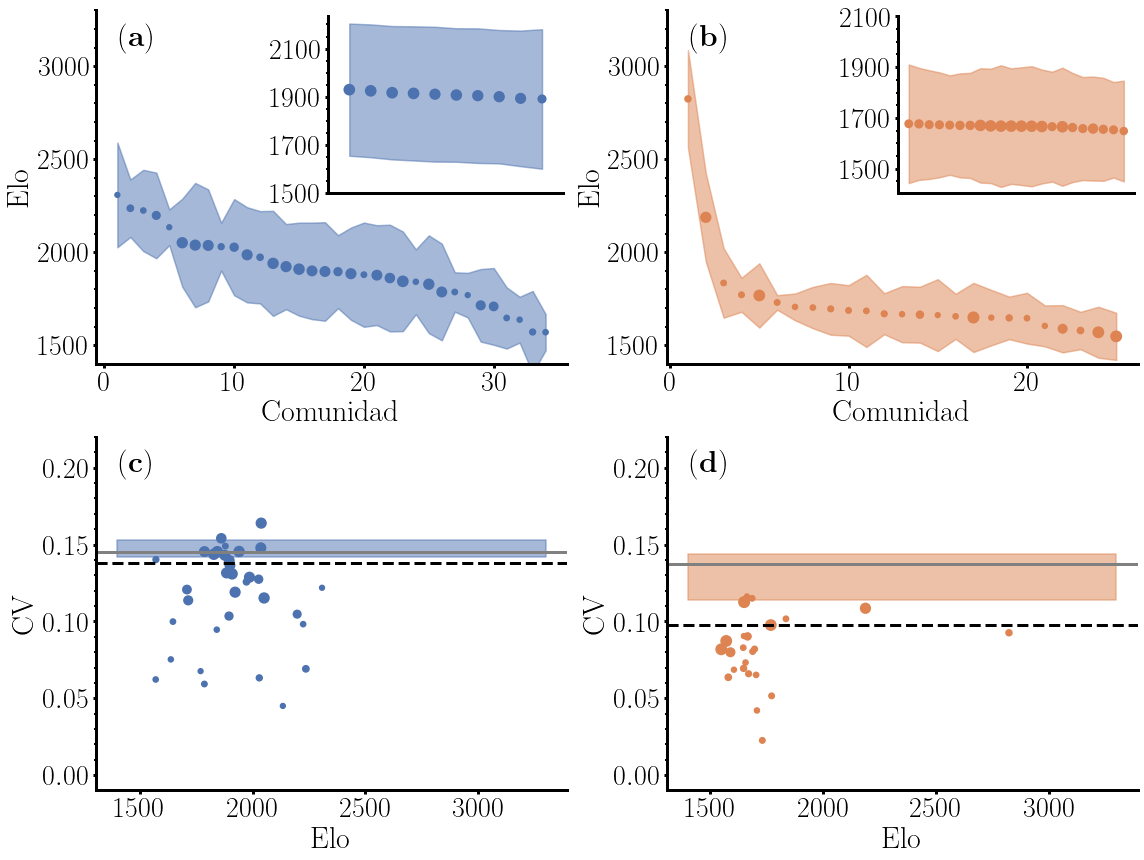

In [37]:
min_size = 10
ncols, nrows = 2, 2
fig, axes = plt.subplots(figsize=(8*ncols, 6*nrows), ncols=ncols, nrows=nrows)
for i, (name, comms_by_name) in enumerate(comm_data.items()):
    g = graphs[name]
    communities = comms_to_comms_by_id(g, comms_by_name)
    
    ax = axes[0,i]
    ax.text(0.05, 0.9, panels[i], fontsize=30, transform=ax.transAxes)
    min_elo, max_elo = 1400, 3300
    ax.set_ylim(min_elo, max_elo)
    ax.set_xlabel(r"$\mathrm{Comunidad}$")
    ax.set_ylabel(r"$\mathrm{Elo}$")
    df = get_community_data(g, communities, min_size=min_size)
    plot_elo_per_community(df, ax=ax)
    #ax.set_xlim(0, 42)

    ax = axes[1,i]
    ax.text(0.05, 0.9, panels[2+i], fontsize=30, transform=ax.transAxes)
    ax.set_xlabel(r"$\mathrm{Elo}$")
    ax.set_ylabel(r"$\mathrm{CV}$")
    ax.scatter(df.MeanElo, df.CV, s=10*np.log(df.Nc), color=f"C{i}")
    ax.axhline(np.std(g.vs["MeanElo"]) / np.mean(g.vs["MeanElo"]), color="gray")
    ax.axhline(np.dot(df.Nc, df.CV) / df.Nc.sum(), linestyle="--", color="k")
    ax.set_ylim(-0.01, 0.22)

for i, (name, comms_by_name) in enumerate(ran_comm_data.items()):
    g = graphs[name]
    communities = comms_to_comms_by_id(g, comms_by_name)

    ax = axes[0,i]
    df = get_community_data(g, communities, min_size=min_size)

    bbox_to_anchor = (.52, .52, .5, .5)
    axins = inset_axes(
        ax, width="100%", height="100%",
        bbox_to_anchor=bbox_to_anchor,
        bbox_transform=ax.transAxes
    )
    plot_elo_per_community(df, ax=axins)
    axins.set_xlim(0, (df.Nc>=min_size).sum()+1)
    axins.set_xticks([])
    yticks = [1500, 1700, 1900, 2100]# if name == "OTB" else [1500, 1700, 1900]
    axins.set_yticks(yticks)
    ax = axes[1,i]
    ax.fill_between(
        [min_elo, max_elo],
        df[df.Nc>=min_size].CV.min(),
        df[df.Nc>=min_size].CV.max(),
         alpha=0.5,
         color=f"C{i}",
        )

sns.despine()
plt.tight_layout()
plt.savefig(FIGS_DIR / "louvain.pdf")
plt.show()

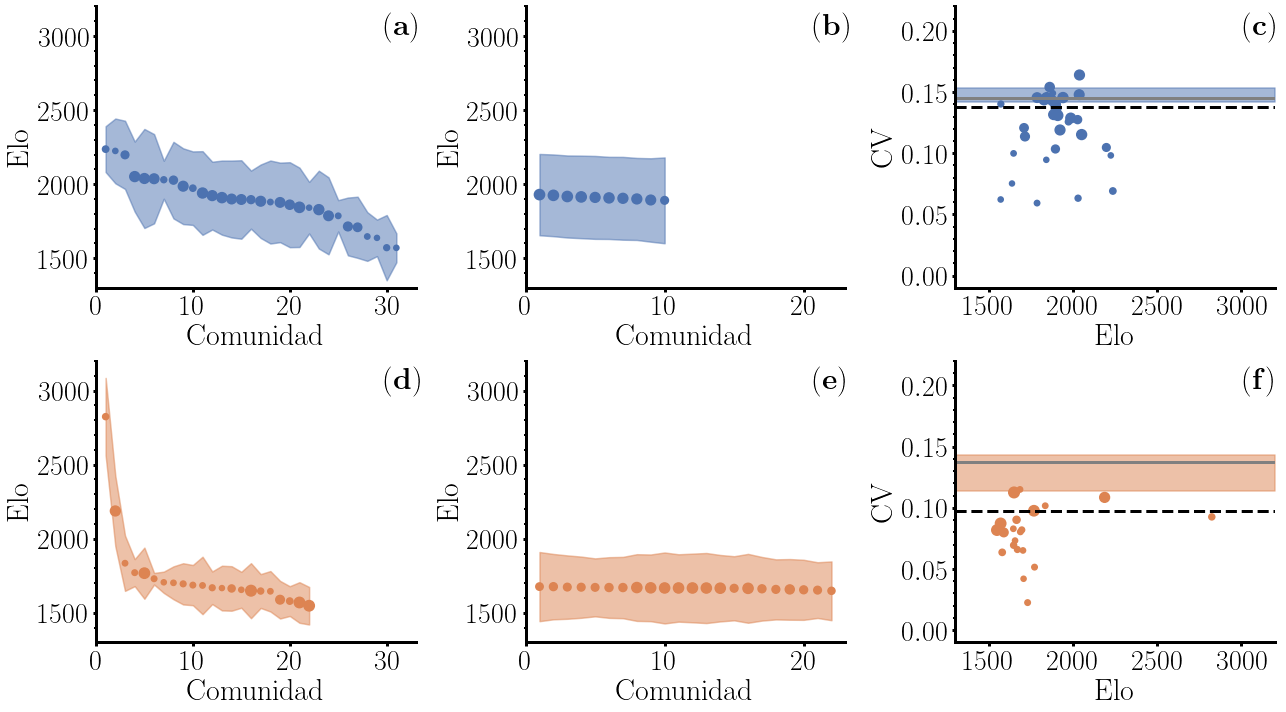

In [66]:
min_size = 10
min_max_elo = {
    #"OTB": (1300, 2700),
    "OTB": (1300, 3200),
    "Portal": (1300, 3200),
}
ncols, nrows = 3, 2
fig, axes = plt.subplots(figsize=(6*ncols, 5*nrows), ncols=ncols, nrows=nrows)
for i, (name, comms_by_name) in enumerate(comm_data.items()):
    g = graphs[name]
    communities = comms_to_comms_by_id(g, comms_by_name)

    ax = axes[i,0]
    ax.text(0.9, 0.9, panels[3*i], fontsize=30, transform=ax.transAxes)
    min_elo, max_elo = min_max_elo[name]
    ax.set_ylim(min_elo, max_elo)
    ax.set_xlabel(r"$\mathrm{Comunidad}$")
    ax.set_ylabel(r"$\mathrm{Elo}$")
    df = get_community_data(g, communities, min_size=min_size+2)
    plot_elo_per_community(df, ax=ax)
    ax.set_xlim(0, 33)
    ax.set_xticks([0, 10, 20, 30])

    ax = axes[i, 2]
    ax.text(0.9, 0.9, panels[3*i+2], fontsize=30, transform=ax.transAxes)
    ax.set_xlabel(r"$\mathrm{Elo}$")
    ax.set_ylabel(r"$\mathrm{CV}$")
    ax.scatter(df.MeanElo, df.CV, s=10*np.log(df.Nc), color=f"C{i}")
    ax.axhline(np.std(g.vs["MeanElo"]) / np.mean(g.vs["MeanElo"]), color="gray")
    ax.axhline(np.dot(df.Nc, df.CV) / df.Nc.sum(), linestyle="--", color="k")
    ax.set_ylim(-0.01, 0.22)

for i, (name, comms_by_name) in enumerate(ran_comm_data.items()):
    g = graphs[name]
    communities = comms_to_comms_by_id(g, comms_by_name)

    ax = axes[i,1]
    ax.set_xlabel(r"$\mathrm{Comunidad}$")
    ax.set_ylabel(r"$\mathrm{Elo}$")
    ax.text(0.9, 0.9, panels[3*i+1], fontsize=30, transform=ax.transAxes)
    df = get_community_data(g, communities, min_size=min_size)
    plot_elo_per_community(df, ax=ax)
    #ax.set_xlim(0, (df.Nc>=min_size).sum()+1)
    ax.set_xlim(0, 23)
    min_elo, max_elo = min_max_elo[name]
    ax.set_ylim(min_elo, max_elo)

    ax = axes[i, 2]
    ax.fill_between(
        [min_elo, max_elo],
        df[df.Nc>=min_size].CV.min(),
        df[df.Nc>=min_size].CV.max(),
         alpha=0.5,
         color=f"C{i}",
        )
    ax.set_xlim(min_elo, max_elo)
    ax.set_xticks([1500, 2000, 2500, 3000])

sns.despine()
plt.tight_layout()
plt.savefig(FIGS_DIR / "leiden.pdf")
plt.show()

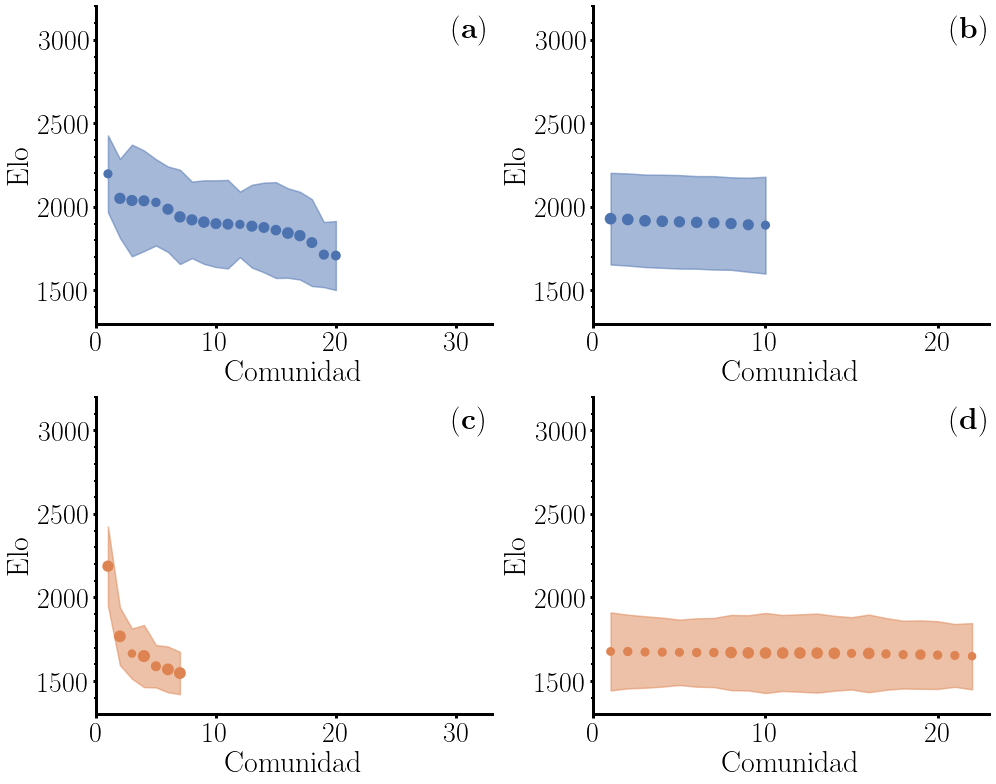

In [42]:
min_size = 10
min_max_elo = {
    #"OTB": (1300, 2700),
    "OTB": (1300, 3200),
    "Portal": (1300, 3200),
}
ncols, nrows = 2, 2
fig, axes = plt.subplots(figsize=(7*ncols, 5.5*nrows), ncols=ncols, nrows=nrows)
for i, (name, comms_by_name) in enumerate(comm_data.items()):
    g = graphs[name]
    mean_elo = np.mean(g.vs["MeanElo"])
    std_elo = np.std(g.vs["MeanElo"])

    communities = comms_to_comms_by_id(g, comms_by_name)
    df = get_community_data(g, communities, min_size=min_size+2)

    ax = axes[i,0]
    ax.text(0.9, 0.9, panels[2*i], fontsize=30, transform=ax.transAxes)
    min_elo, max_elo = min_max_elo[name]
    ax.set_ylim(min_elo, max_elo)
    ax.set_xlabel(r"$\mathrm{Comunidad}$")
    ax.set_ylabel(r"$\mathrm{Elo}$")
    plot_elo_per_community(df, ax=ax)
    ax.set_xlim(0, 33)
    ax.set_xticks([0, 10, 20, 30])

for i, (name, comms_by_name) in enumerate(ran_comm_data.items()):
    g = graphs[name]
    communities = comms_to_comms_by_id(g, comms_by_name)

    ax = axes[i,1]
    ax.set_xlabel(r"$\mathrm{Comunidad}$")
    ax.set_ylabel(r"$\mathrm{Elo}$")
    ax.text(0.9, 0.9, panels[2*i+1], fontsize=30, transform=ax.transAxes)
    df = get_community_data(g, communities, min_size=min_size)
    plot_elo_per_community(df, ax=ax)
    #ax.set_xlim(0, (df.Nc>=min_size).sum()+1)
    ax.set_xlim(0, 23)
    min_elo, max_elo = min_max_elo[name]
    ax.set_ylim(min_elo, max_elo)

sns.despine()
plt.tight_layout()
plt.savefig(FIGS_DIR / "communities_leiden.pdf")
plt.show()

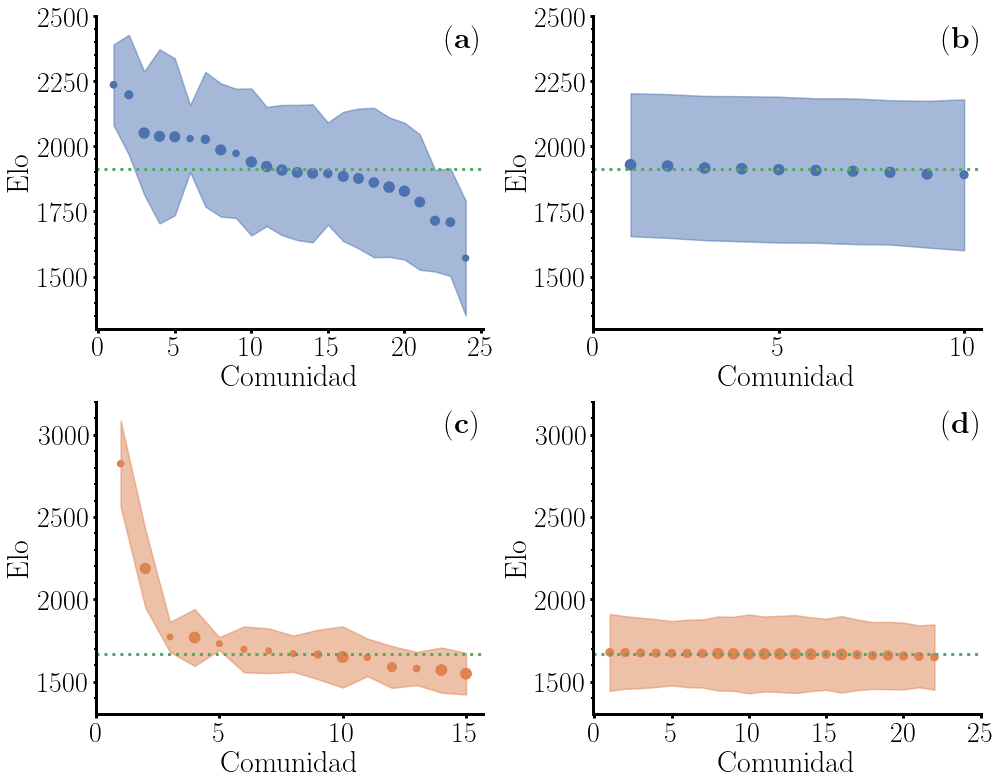

In [134]:
min_size = 20
min_max_elo = {
    #"OTB": (1300, 2700),
    "OTB": (1300, 2500),
    "Portal": (1300, 3200),
}
ncols, nrows = 2, 2
fig, axes = plt.subplots(figsize=(7*ncols, 5.5*nrows), ncols=ncols, nrows=nrows)
for i, (name, comms_by_name) in enumerate(comm_data.items()):
    g = graphs[name]
    communities = comms_to_comms_by_id(g, comms_by_name)
    df = get_community_data(g, communities, min_size=min_size)

    ax = axes[i,0]
    ax.text(0.9, 0.9, panels[2*i], fontsize=30, transform=ax.transAxes)
    min_elo, max_elo = min_max_elo[name]
    ax.set_ylim(min_elo, max_elo)
    ax.set_xlabel(r"$\mathrm{Comunidad}$")
    ax.set_ylabel(r"$\mathrm{Elo}$")
    plot_elo_per_community(df, ax=ax)
    ax.set_xticks(range(0, (df.Nc>=min_size).sum()+5, 5))
    #ax.set_xlim(0, 23)
    #ax.set_xticks([0, 10, 20])

for i, (name, comms_by_name) in enumerate(ran_comm_data.items()):
    g = graphs[name]
    mean_elo = np.mean(g.vs["MeanElo"])
    std_elo = np.std(g.vs["MeanElo"])
    communities = comms_to_comms_by_id(g, comms_by_name)

    ax = axes[i,1]

    ax.set_xlabel(r"$\mathrm{Comunidad}$")
    ax.set_ylabel(r"$\mathrm{Elo}$")
    ax.text(0.9, 0.9, panels[2*i+1], fontsize=30, transform=ax.transAxes)
    df = get_community_data(g, communities, min_size=min_size)
    plot_elo_per_community(df, ax=ax)
    #ax.set_xlim(0, (df.Nc>=min_size).sum()+2)
    ax.set_xticks(range(0, (df.Nc>=min_size).sum()+5, 5))
    #ax.set_xlim(0, 23)
    min_elo, max_elo = min_max_elo[name]
    ax.set_ylim(min_elo, max_elo)

    for ax in axes[i,:]:
        ax.axhline(mean_elo, color="C2", linestyle=":")
        #ax.axhline(mean_elo - std_elo, linestyle="--", color="gray")
        #ax.axhline(mean_elo + std_elo, linestyle="--", color="gray")

sns.despine()
plt.tight_layout()
plt.savefig(FIGS_DIR / "communities_leiden.pdf")
plt.show()

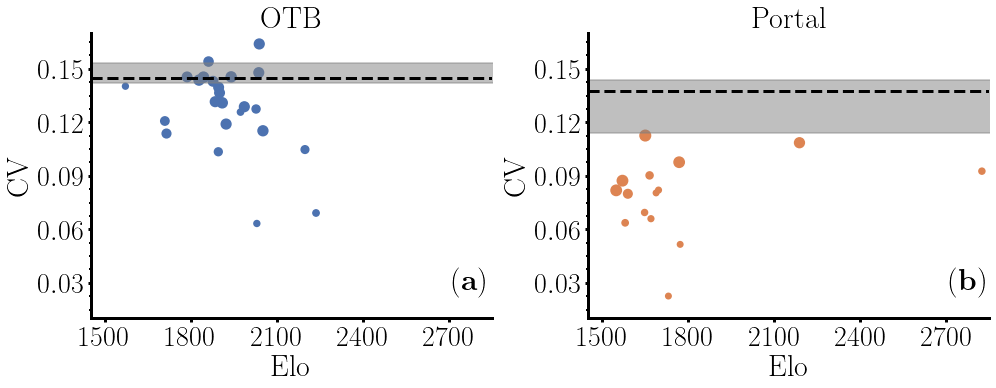

In [136]:
min_size = 20
min_max_elo = {
    #"OTB": (1300, 2700),
    "OTB": (1300, 3200),
    "Portal": (1300, 3200),
}
ncols, nrows = 2, 1
fig, axes = plt.subplots(figsize=(7*ncols, 5.5*nrows), ncols=ncols, nrows=nrows)
for i, (name, comms_by_name) in enumerate(comm_data.items()):
    g = graphs[name]
    communities = comms_to_comms_by_id(g, comms_by_name)
    df = get_community_data(g, communities, min_size=min_size)

    ax = axes[i]
    ax.text(0.9, 0.1, panels[i], fontsize=30, transform=ax.transAxes)
    ax.set_xlabel(r"$\mathrm{Elo}$")
    ax.set_ylabel(r"$\mathrm{CV}$")
    ax.scatter(df.MeanElo, df.CV, s=10*np.log(df.Nc), color=f"C{i}")
    ax.axhline(np.std(g.vs["MeanElo"]) / np.mean(g.vs["MeanElo"]), linestyle="--", color="k")
    #ax.axhline(np.std(g.vs["MeanElo"]) / np.mean(g.vs["MeanElo"]), color="gray")
    #ax.axhline(np.dot(df.Nc, df.CV) / df.Nc.sum(), linestyle="--", color="k")

for i, (name, comms_by_name) in enumerate(ran_comm_data.items()):
    g = graphs[name]
    communities = comms_to_comms_by_id(g, comms_by_name)
    df = get_community_data(g, communities, min_size=min_size)

    ax = axes[i]
    ax.fill_between(
        [min_elo, max_elo],
        df[df.Nc>=min_size].CV.min(),
        df[df.Nc>=min_size].CV.max(),
         alpha=0.5,
         #color=f"C{i}",
         color="gray"
        )
    #ax.set_xlim(min_elo, max_elo)
    #ax.set_xticks([1500, 2000, 2500, 3000])

    ax.set_ylim(0.01, 0.17)
    ax.set_xlim(1450, 2850)
    ax.set_xticks([1500, 1800, 2100, 2400, 2700])
    ax.set_yticks([0.03, 0.06, 0.09, 0.12, 0.15])

axes[0].set_title(database_latex["OTB"], fontsize=30)
axes[1].set_title(database_latex["Portal"], fontsize=30)

sns.despine()
plt.tight_layout()
plt.savefig(FIGS_DIR / "communities_leiden_CV.pdf")
plt.show()

In [82]:
def get_normalized_count(database, random: bool = False, iteration: int = 1):
    filename = (
        f"{database}" +
        ("_random" if random else "") +
        f"_newman_{iteration:02d}.txt"
    )
    filename = f"OM_{database}_flux_year_2015_undirected_comm_newman_K2_run{iteration}.txt"
    #filename = f"OM_{database}_flux_comm_newman_K2_run{iteration}.txt"

    df = pd.read_csv(
        ARTIFACTS_DIR / "newman_old" / filename,
        sep=" ",
        names=["ID", "Categoría", "C0", "C1"],
        index_col="ID",
        header=None,
    )
    df["Comunidad"] = df[["C0", "C1"]].idxmax(axis=1)
    aux = (
        df[["Categoría", "Comunidad"]].value_counts()
        .reset_index()
        .rename(columns={0: "COUNT"})
        .sort_values(by="Categoría")
    )
    norm_dict = aux.groupby("Categoría").sum()["COUNT"].to_dict()
    aux["Ocupación"] = [count / norm_dict[label] for count, label in aux[["COUNT", "Categoría"]].values]
    return aux, df


In [83]:
data

,Categoría,Comunidad,COUNT,Ocupación
8,Candidate_Master,C0,8856,0.706502
11,Candidate_Master,C1,3679,0.293498
1,Class_A,C0,23427,0.500246
2,Class_A,C1,23404,0.499754
3,Class_B,C1,22150,0.569951
4,Class_B,C0,16713,0.430049
6,Class_C,C1,14708,0.583767
7,Class_C,C0,10487,0.416233
13,Class_D,C0,2607,0.383157
10,Class_D,C1,4197,0.616843


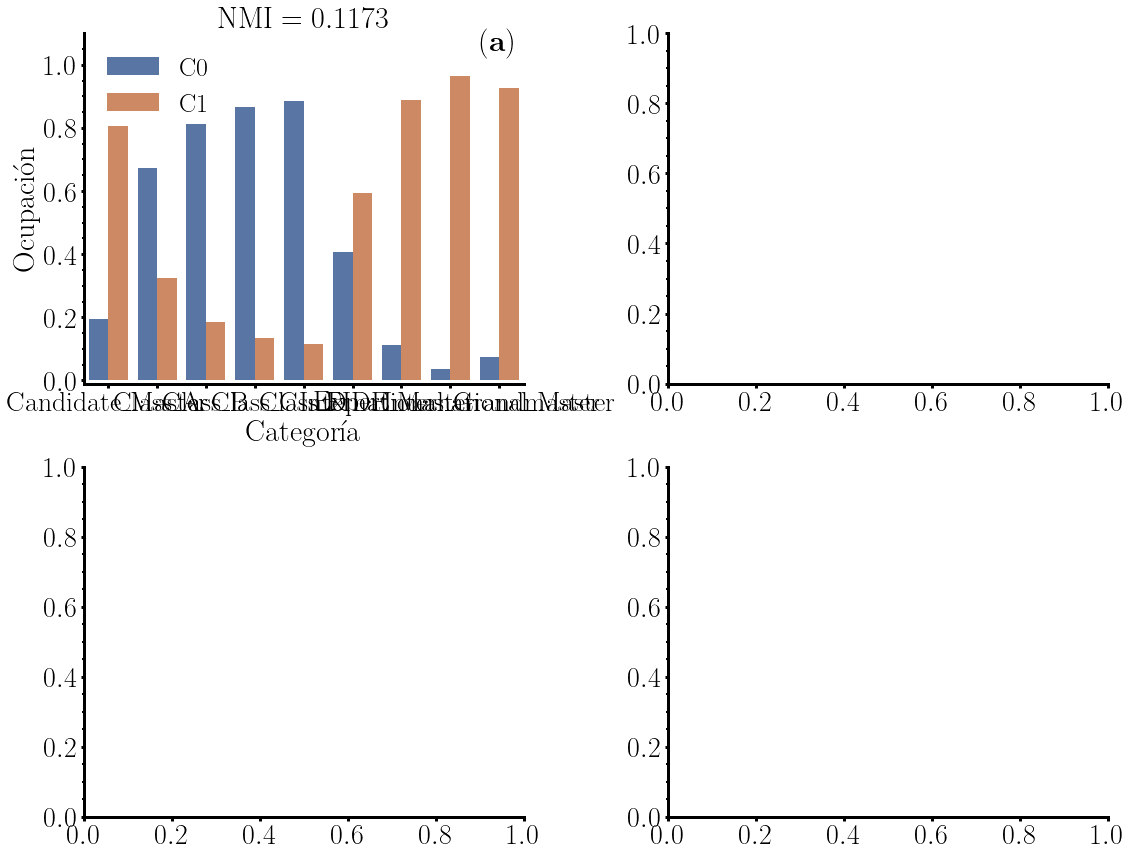

In [137]:
ncols, nrows = 2, 2
fig, axes = plt.subplots(figsize=(8*ncols, 6*nrows), ncols=ncols, nrows=nrows)
#for i, name in enumerate(["OTB", "Portal"]):
for i, name in enumerate(["OTB"]):
    ax = axes[0,i]
    ax.set_ylim(-0.01, 1.1)
    ax.text(0.9, 0.95, panels[i], fontsize=30, transform=ax.transAxes)
    data, df = get_normalized_count(name, iteration=8)
    nmi = normalized_mutual_info_score(df["Categoría"], df["Comunidad"])
    ax.set_title(r"$\text{NMI} = " + r"{{{:.4f}}}$".format(nmi), fontsize=30)
    database = getattr(Database, name)
    sns.barplot(data=data, x="Categoría", y="Ocupación", hue="Comunidad", ax=ax)
for i, ax in enumerate(axes.flatten()):
    if i == 0:
        ax.legend(frameon=False, loc="upper left")
    else:
        ax.legend([], [], frameon=False)
sns.despine()
plt.tight_layout()
plt.savefig(FIGS_DIR / "newman_communities.pdf")
plt.show()

In [85]:
max_nmi = 0
for i, name in enumerate(["OTB"]):
    for it in range(20):
        try:
            data, df = get_normalized_count(name, iteration=it)
        except:
            continue
        nmi = normalized_mutual_info_score(df["Categoría"], df["Comunidad"])
        if nmi > max_nmi:
            max_nmi = nmi
            print(it, nmi)

1 0.11020413088530381
8 0.11732729074296351


In [82]:
labels_true = [0, 0, 0, 0, 1, 1]
labels_pred = [0, 0, 1, 1, 2, 2]
normalized_mutual_info_score(labels_true, labels_pred)

0.7336804366512113

In [3]:
database = Database.OTB
g = read_gml(database)
print(g.summary())
g = read_gml(database, rewired=True)
print(g.summary())

IGRAPH UN-- 198494 3874277 -- 
+ attr: MeanElo (v), StdElo (v), id (v), label (v), name (v), NUMBEROFGAMES (e)


FileNotFoundError: [Errno 2] No such file or directory: '/home/nahuel/chessnet/artifacts/OM_OTB_201609_rewired.gml'

In [7]:
database = Database.Portal
g = read_gml(database)
print(g.summary())
g = read_gml(database, rewired=True)
print(g.summary())

IGRAPH UN-- 212875 7594313 -- 
+ attr: MeanElo (v), StdElo (v), id (v), label (v), name (v), NUMBEROFGAMES (e)


FileNotFoundError: [Errno 2] No such file or directory: '/home/nahuel/chessnet/artifacts/OM_Portal_201510_rewired.gml'

In [8]:
read_pickle(Database.Portal).summary()

'IGRAPH UN-- 212875 7594313 -- \n+ attr: MeanElo (v), StdElo (v), name (v), NUMBER_OF_GAMES (e)'

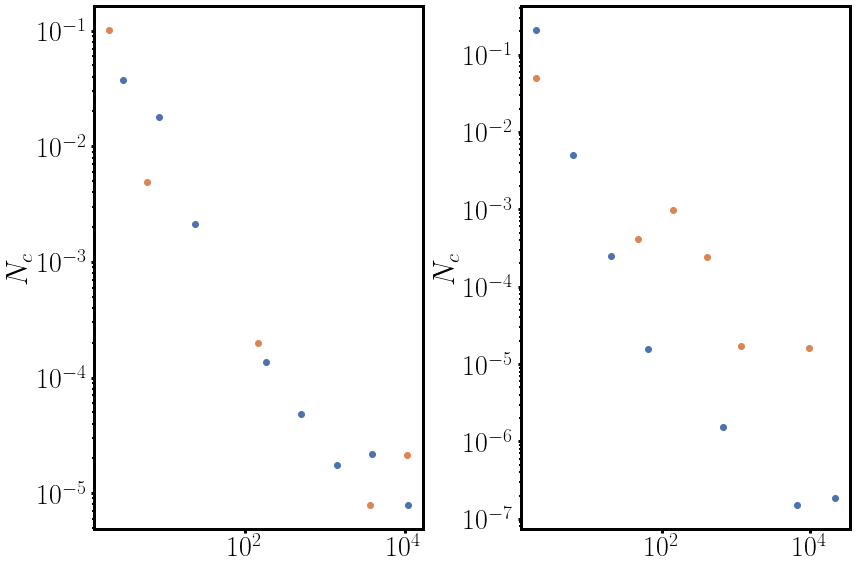

In [32]:

ncols, nrows = 2, 1
fig, axes = plt.subplots(ncols=ncols, nrows=nrows)

for i, name in enumerate(["OTB", "Portal"]):

    ax = axes[i]
    ax.set_ylabel(r"$N_c$")
    ax.set_xscale("log")
    ax.set_yscale("log")

    net_data = [len(comm) for comm in comm_data[name].communities]
    ran_data = [len(comm) for comm in ran_comm_data[name].communities]
    for data in [net_data, ran_data]:
        min_value, max_value = min(data), max(data)
        bins = np.logspace(np.log10(min_value), np.log10(max_value+1), 10)
        #bins = 20
        freq, bin_edges = np.histogram(data, bins=bins, density=True)
        ax.plot(bin_edges[:-1], freq, 'o')


plt.tight_layout()
plt.show()


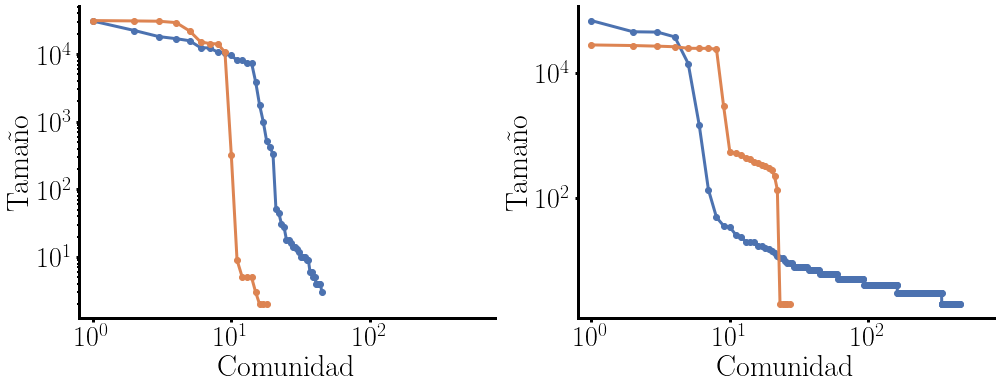

In [41]:
ncols, nrows = 2, 1
fig, axes = plt.subplots(figsize=(7*ncols, 5.5*nrows), ncols=ncols, nrows=nrows)

for i, name in enumerate(["OTB", "Portal"]):

    ax = axes[i]
    ax.set_xlabel("Comunidad")
    ax.set_ylabel("Tamaño")
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xticks([1, 10, 100])
    ax.set_xlim(0.8, 800)
    net_data = [len(comm) for comm in comm_data[name].communities]
    ran_data = [len(comm) for comm in ran_comm_data[name].communities]
    for data in [net_data, ran_data]:
        Y = sorted(data, reverse=True)
        X = range(1, len(Y)+1)
        ax.plot(X, Y, 'o-')

sns.despine()
plt.tight_layout()
plt.show()


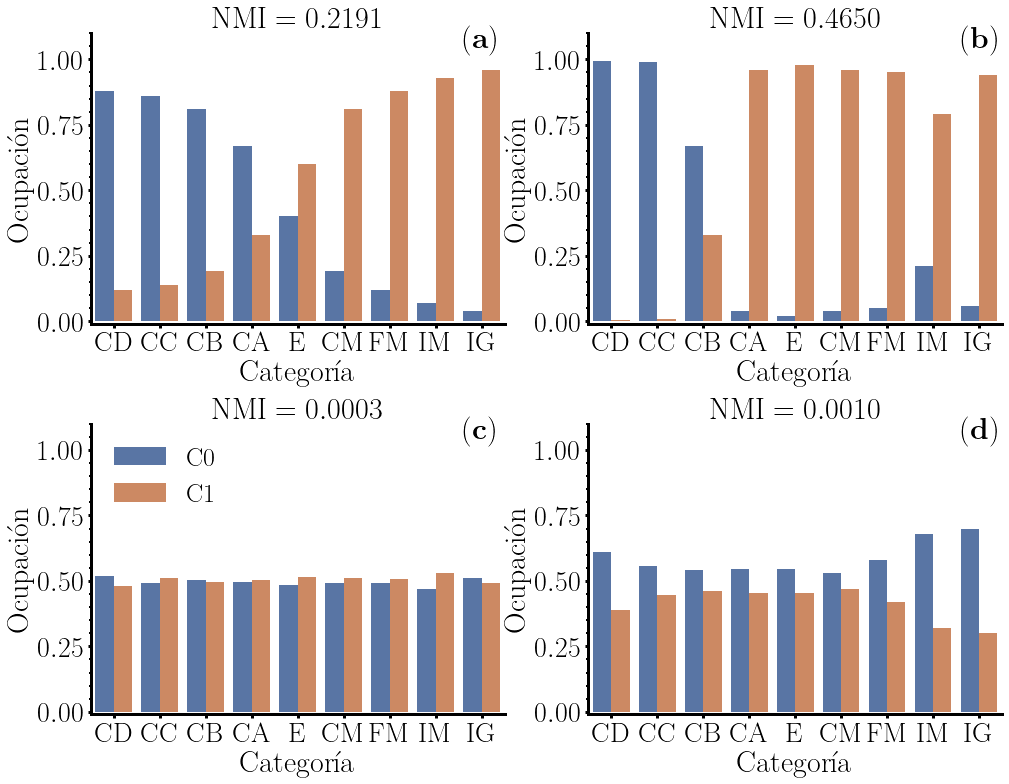

In [156]:
df_OTB = pd.DataFrame(
    [
        ["CD", "C0", 0.88],
        ["CD", "C1", 0.12],
        ["CC", "C0", 0.86],
        ["CC", "C1", 0.14],
        ["CB", "C0", 0.81],
        ["CB", "C1", 0.19],
        ["CA", "C0", 0.67],
        ["CA", "C1", 0.33],
        ["E",  "C0", 0.40],
        ["E",  "C1", 0.60],
        ["CM", "C0", 0.19],
        ["CM", "C1", 0.81],
        ["FM", "C0", 0.12],
        ["FM", "C1", 0.88],
        ["IM", "C0", 0.07],
        ["IM", "C1", 0.93],
        ["IG", "C0", 0.04],
        ["IG", "C1", 0.96],
    ],
    columns=["Categoría", "Comunidad", "Ocupación"]
)

df_Portal = pd.DataFrame(
    [
        ["CD", "C0", 0.995],
        ["CD", "C1", 0.005],
        ["CC", "C0", 0.99],
        ["CC", "C1", 0.01],
        ["CB", "C0", 0.67],
        ["CB", "C1", 0.33],
        ["CA", "C0", 0.04],
        ["CA", "C1", 0.96],
        ["E",  "C0", 0.02],
        ["E",  "C1", 0.98],
        ["CM", "C0", 0.04],
        ["CM", "C1", 0.96],
        ["FM", "C0", 0.05],
        ["FM", "C1", 0.95],
        ["IM", "C0", 0.21],
        ["IM", "C1", 0.79],
        ["IG", "C0", 0.06],
        ["IG", "C1", 0.94],
    ],
    columns=["Categoría", "Comunidad", "Ocupación"]
)

df_OTB_ran = pd.DataFrame(
    [
        ["CD", "C0", 0.52],
        ["CD", "C1", 0.48],
        ["CC", "C0", 0.49],
        ["CC", "C1", 0.51],
        ["CB", "C0", 0.505],
        ["CB", "C1", 0.495],
        ["CA", "C0", 0.496],
        ["CA", "C1", 0.504],
        ["E",  "C0", 0.485],
        ["E",  "C1", 0.515],
        ["CM", "C0", 0.49],
        ["CM", "C1", 0.51],
        ["FM", "C0", 0.493],
        ["FM", "C1", 0.507],
        ["IM", "C0", 0.47],
        ["IM", "C1", 0.53],
        ["IG", "C0", 0.51],
        ["IG", "C1", 0.49],
    ],
    columns=["Categoría", "Comunidad", "Ocupación"]
)

df_Portal_ran = pd.DataFrame(
    [
        ["CD", "C0", 0.61],
        ["CD", "C1", 0.39],
        ["CC", "C0", 0.555],
        ["CC", "C1", 0.445],
        ["CB", "C0", 0.54],
        ["CB", "C1", 0.46],
        ["CA", "C0", 0.545],
        ["CA", "C1", 0.455],
        ["E",  "C0", 0.545],
        ["E",  "C1", 0.455],
        ["CM", "C0", 0.53],
        ["CM", "C1", 0.47],
        ["FM", "C0", 0.58],
        ["FM", "C1", 0.42],
        ["IM", "C0", 0.68],
        ["IM", "C1", 0.32],
        ["IG", "C0", 0.70],
        ["IG", "C1", 0.30],
    ],
    columns=["Categoría", "Comunidad", "Ocupación"]
)

nmi_values = [0.2191, 0.4650, 0.0003, 0.0010]

ncols, nrows = 2, 2
fig, axes = plt.subplots(figsize=(7*ncols, 5.5*nrows), ncols=ncols, nrows=nrows)

ax = axes[0,0]
sns.barplot(data=df_OTB, x="Categoría", y="Ocupación", hue="Comunidad", ax=ax)
ax = axes[0,1]
sns.barplot(data=df_Portal, x="Categoría", y="Ocupación", hue="Comunidad", ax=ax)

ax = axes[1,0]
sns.barplot(data=df_OTB_ran, x="Categoría", y="Ocupación", hue="Comunidad", ax=ax)
ax = axes[1,1]
sns.barplot(data=df_Portal_ran, x="Categoría", y="Ocupación", hue="Comunidad", ax=ax)

for i, ax in enumerate(axes.flatten()):
    ax.set_ylim(-0.01, 1.1)
    ax.text(0.9, 0.95, panels[i], fontsize=30, transform=ax.transAxes)
    nmi = nmi_values[i]
    ax.set_title(r"$\text{NMI} = " + r"{{{:.4f}}}$".format(nmi), fontsize=30)
    if i == 2:
        ax.legend(frameon=False, loc="upper left")
    else:
        ax.legend([], [], frameon=False)
sns.despine()
plt.tight_layout()
plt.savefig(FIGS_DIR / "newman_communities.pdf")
plt.show()